# Contextualized embedding with transformer models illustrated

In this notebook, we begin to peek under the hood of a BERT transformer model to understand how contextualized embedding work.
We then also introduce a couple of potential use cases that leverage contextualized embeddings.

<br>
<a target="_blank" href="https://colab.research.google.com/github/haukelicht/advanced_text_analysis/blob/main/notebooks/embedding/contextualized_embedding_transformers_explained.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Setup

#### Colab

In [217]:
# check if on colab
COLAB = True
try:
    import google.colab
except:
    COLAB=False

if COLAB:
    # shallow clone of current state of main branch 
    !git clone --branch main --single-branch --depth 1 --filter=blob:none https://github.com/haukelicht/advanced_text_analysis.git

    !pip install -q umap-learn~=0.5.9.post2 bertviz==1.4.1


#### Required packages

In [218]:
from pathlib import Path
import numpy as np
import pandas as pd

import torch
from transformers import BertTokenizer, BertModel
from transformers import (
    BertForMaskedLM, 
    BertModel, BertTokenizer
)

from bertviz import head_view
from bertviz.transformers_neuron_view import BertModel as BertVizModel 
from bertviz.transformers_neuron_view import BertTokenizer as BertVizTokenizer
from bertviz.neuron_view import show

import umap
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

### Some terminology

Here are the most important peices of the transformer model we will work wit:

- `model()` -- this _is_ the model (has been pre-trained, we only use it to compute contextualized embeddings)
- `tokenizer()` -- this is the tokenizer associated with the model that converts raw texts into sequences of token IDs that point tot the corresponding tokens' location in the model's input embedding matrix
- `outputs` -- this is what the model _outputs_ when we process an input sentence through it
-  `outputs.hidden_states` -- these are the contextualized embeddings prodcued at each layer
-  `outputs.last_hidden_state` -- this is the contextualized embeddings at the _final_ layer


## Intro to the `transformers` library

In python, the standard library to work with transformer models is `transformers`.
It provides access to pre-trained transformers models through its [model hub]().
The `transformers` library is developed and maintained by Hugging Face Inc.

### pre-trained models and tokenizers

To use a pre-trained model for embedding texts, we need two things:

1. the model's tokenizer
1. and of course the model itself

We use the model to process a text though its **layers** to obtain the text's **embedding**.
But to be able to do this, we need to **tokenize** the text to convert it into number – because deep neural network can only process with numbers, not with raw text.

Below we load a pre-trained BERT model, specifically "bert-base-uncased", which is a smallish version of BERT (hence 'base' instead of 'large') that does not distinguish between upper- and lowercase letters (hence 'uncased'). 

In [219]:
# define the name of the model we want to load
model_id = 'bert-base-uncased'

# load the pre-trained model and tokenizer 
model = BertModel.from_pretrained(model_id)
tokenizer = BertTokenizer.from_pretrained(model_id)
# NOTE: this will trigger downloading the model and tokenizer if you haven't done so before

Let's get some information about the model by looking at its configuration attribute (`config`):

In [220]:
# let's get some important information about the model
print('embedding dimensionality:', model.config.hidden_size)
print('number of layers:', model.config.num_hidden_layers)
print('vocabulary size:', model.config.vocab_size)

embedding dimensionality: 768
number of layers: 12
vocabulary size: 30522


In [221]:
# lets' have a look at the model architecture
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

- the models first component is a `BertEmbeddings` module that contains
    1. the initial word embedding layer
    2. the positional embedding
- after this we have the `BertEncoder` module that consists of 12 `BertLayer`s

If we just want to get the initial word embeddings, we can access them like this.

In [222]:
model.embeddings.word_embeddings.weight.shape

torch.Size([30522, 768])

In [223]:
print(model.embeddings.word_embeddings)

# let's get the first five values of the first embedding
model.embeddings.word_embeddings.weight[0][:5].detach().numpy()

Embedding(30522, 768, padding_idx=0)


array([-0.01018257, -0.06154883, -0.02649689, -0.0420608 ,  0.00116716],
      dtype=float32)

notes: 

- the layers are attributes of the `model` and they are organized and nested as can be seen when calling `print(model)` 
- we get the actual parameters of the model from a layer's "weigths" (weights is just the machine learning term for parameters)
- weights are $n$-dimensional arrays (called "tensors" in `pytorch` etc.) and we can index them just like numpy arrays
- we use `detach()` because the model and its weights (parameters) are tracked by the optimization algorithm, which we dont need when we only want to see the weight values

But the main reason we use BERT & Co. is to obtain contextualized embeddings.

## Contextualized embedding

To illustrate how contextualized embedding works in transformers, we will first look at how embeddings of the same word differ if their context differs.

Let's take two sentences what contain the word "bank" but use it with different meanings:

In [224]:
sentences = [
    "Today, I will hike along the bank of a river.",
    "Today, I will open a new account at my bank and deposit some money.",
]

To get the transformer embedding of the word "bank" in these two sentences, we need to follow three steps:

1. tokenize the texts and convert tokens into tokens IDs (to look-up their input embeddings)
2. process these inputs through the model
3. locate the embedding of the focal word in the two sentences.

#### 1) tokenize

The tokenizer converts the text into tokens and maps the tokens to token IDs

Token IDs indicate tokens' locations in the tokenizers vocabulary and hence the model's input embedding. 

In [225]:
inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)

In [226]:
inputs

{'input_ids': tensor([[  101,  2651,  1010,  1045,  2097, 21857,  2247,  1996,  2924,  1997,
          1037,  2314,  1012,   102,     0,     0,     0,     0],
        [  101,  2651,  1010,  1045,  2097,  2330,  1037,  2047,  4070,  2012,
          2026,  2924,  1998, 12816,  2070,  2769,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [227]:
inputs['input_ids']

tensor([[  101,  2651,  1010,  1045,  2097, 21857,  2247,  1996,  2924,  1997,
          1037,  2314,  1012,   102,     0,     0,     0,     0],
        [  101,  2651,  1010,  1045,  2097,  2330,  1037,  2047,  4070,  2012,
          2026,  2924,  1998, 12816,  2070,  2769,  1012,   102]])

We can "decode" these token IDs into their tokens:

In [228]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

['[CLS]',
 'today',
 ',',
 'i',
 'will',
 'hike',
 'along',
 'the',
 'bank',
 'of',
 'a',
 'river',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Notes: 

- the `[CLS]` token is a special token used to summarize the information in a sequence (e.g., for classification tasks)
- the `[SEP]` token is the special "separator" token that indicates sequence boundaries
- the `[PAD]` token is the special "padding" token that is appended to sequences that are shorter than the other sequences in a batch to make the input rectengular (e.g., all rows have an equal number of columns)

In [229]:
# let's use the tokenizer to get the token ID of the focal word 
focal_word_id = tokenizer.convert_tokens_to_ids('bank')
focal_word_id

2924

In [230]:
# create maks that is true where input ID == focal word ID
mask = inputs['input_ids'] == focal_word_id
mask

tensor([[False, False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False]])

#### 2) embed (process through model)

In [231]:
# get the intial emebdding of the focal word ("bank")
model.embeddings.word_embeddings.weight[focal_word_id].shape

torch.Size([768])

In [232]:
model.embeddings.word_embeddings.weight[focal_word_id]

tensor([-1.9130e-02, -6.4559e-02, -9.1287e-02, -7.7617e-02, -2.5319e-02,
         2.2042e-02,  1.8521e-02,  1.9638e-02,  1.6894e-02, -6.7071e-03,
         4.6948e-02, -2.8793e-02, -5.1419e-02, -1.9251e-02, -4.4896e-02,
         1.7663e-02, -5.0461e-02, -1.0894e-02,  4.8693e-02, -1.1041e-01,
        -5.1122e-02, -3.7074e-02,  2.8857e-02, -5.1460e-02,  1.6076e-02,
        -1.3581e-02, -5.3576e-02,  1.8215e-02,  1.7810e-02, -3.5791e-02,
         1.4486e-02,  6.1049e-02, -3.5176e-02,  1.3783e-02, -4.3533e-02,
        -3.7994e-03,  2.8376e-02, -3.9677e-03, -4.0414e-02,  8.1182e-02,
         3.3673e-02, -6.4177e-02, -3.2234e-02, -8.0122e-03, -5.0072e-02,
        -7.4676e-02,  4.7598e-02,  2.7593e-02, -7.9850e-02, -4.5297e-03,
         3.6703e-02,  4.8812e-02, -2.9139e-02, -2.9133e-03, -4.9293e-02,
        -1.9132e-02, -8.3310e-02, -8.3380e-04, -2.7214e-02, -5.3870e-02,
        -1.3290e-02, -1.7759e-03, -3.1814e-02, -5.9626e-02, -2.0356e-02,
         2.4419e-02, -3.9318e-02,  8.7874e-03, -3.6

In [233]:
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

**_Note:_** We use `torch.no_grad()` to disable gradient tracking, which is used for "back propagation" – the method used to optimize deep neural networks' parameters  

In [234]:
print(type(outputs))
# list the object's attributes
list(dict(outputs).keys())

<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>


['last_hidden_state', 'pooler_output', 'hidden_states']

In [235]:
outputs.hidden_states[3].shape

torch.Size([2, 18, 768])

In [236]:
# hiden states are the embeddings after each layer
len(outputs.hidden_states)

13

In [237]:
# the final embedding can be accessed like this: 
outputs.hidden_states[-1][0][0].shape

torch.Size([768])

In [238]:
# let'S look at the shape:
outputs.hidden_states[-1].shape

torch.Size([2, 18, 768])

#### 3) get the words' contextualized embeddings 

In [239]:
# final transformer embeddings of bank in different contexts
embeddings = outputs.last_hidden_state[mask]

In [240]:
embeddings.shape

torch.Size([2, 768])

In [241]:
embeddings[:3]

tensor([[-0.0908, -0.6298,  0.1233,  ..., -0.5037, -1.1361,  0.4891],
        [ 1.0010, -0.1533,  0.8765,  ..., -0.4645, -0.3100,  0.0667]])

In [242]:
# compute cosine similarity between the two embeddings
cosine_similarity(embeddings[0].reshape(1, -1), embeddings[1].reshape(1, -1))

array([[0.49588168]], dtype=float32)

Below you can see that the similarity of "bank"'s transformer embedding deepends on the model layer we look at.

In [244]:
# iterate over all layers
for i, layer in enumerate(outputs.hidden_states):
    # skip input embeddings
    if i == 0:
        continue
    embeddings = layer[mask]
    similarity = cosine_similarity(embeddings[0].reshape(1, -1), embeddings[1].reshape(1, -1))
    print(f'layer {i}: {similarity}')

layer 1: [[0.69466114]]
layer 2: [[0.60061365]]
layer 3: [[0.51213026]]
layer 4: [[0.48320824]]
layer 5: [[0.4523459]]
layer 6: [[0.4516649]]
layer 7: [[0.43999174]]
layer 8: [[0.40654674]]
layer 9: [[0.4039666]]
layer 10: [[0.45446888]]
layer 11: [[0.4963351]]
layer 12: [[0.49588168]]


### 🔥 Competition 🔥

**Try it your self!** 

- Define a pair of sentences that use a word with different meanings.
- Whoever gets the **lowest similar score** (at the final layer of `bert-base-uncase`) for their example pair wins!

*Bonus:* Can you think of a word from your research domain or area of interest that has multiple meanins. If so, does BERT seem to distinguish these meanings?

## Attention &mdash; peeking under the hood

Let's use the amazing `bertviz` library to have a deeper look into the workings of transformers.
Let's define 

In [178]:
sentence = "Today, I will hike along the bank of a river."

### 🔥 Exercise 🔥

Use the interactive attention head and neuron views below to answer the following questions

1. In what layers does BERT attend to the "bank"'s context token "river"? And which head focuses the most on this context word?
1. What other context tokens of "bank" does BERT attend to across layers?
1. How does that change across layers?

### Head View

<b>The head view visualizes attention in one or more heads from a single Transformer layer.</b> Each line shows the attention from one token (left) to another (right). Line weight reflects the attention value (ranges from 0 to 1), while line color identifies the attention head. When multiple heads are selected (indicated by the colored tiles at the top), the corresponding  visualizations are overlaid onto one another.  For a more detailed explanation of attention in Transformer models, please refer to the [blog](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1).

In [179]:
# load the model
model = BertModel.from_pretrained(model_id, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_id)

In [180]:
# retrieve attention weights
inputs = tokenizer.encode_plus(sentence, return_tensors='pt')
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

In [181]:
# visualize
head_view(attention, tokens)

<IPython.core.display.Javascript object>

#### *Usage*

- **Hover** over any **token** on the left/right side of the visualization to filter attention from/to that token. <br/>
- **Double-click** on any of the **colored tiles** at the top to filter to the corresponding attention head.<br/>
- **Single-click** on any of the **colored tiles** to toggle selection of the corresponding attention head. <br/>
- **Click** on the **Layer** drop-down to change the model layer (zero-indexed).

### Neuron View
<b>The neuron view visualizes the intermediate representations (e.g. query and key vectors) that are used to compute attention.</b> In the collapsed view (initial state), the lines show the attention from each token (left) to every other token (right). In the expanded view, the tool traces the chain of computations that produce these attention weights. For a detailed explanation of the attention mechanism, please refer to the [blog](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1).

In [182]:
bertviz_model = BertVizModel.from_pretrained(model_id, output_attentions=True)
bertviz_tokenizer = BertVizTokenizer.from_pretrained(model_id)
show(bertviz_model, 'bert', bertviz_tokenizer, sentence, layer=4, head=3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### *Usage*

- **Hover** over any of the tokens on the left side of the visualization to filter attention from that token.<br/>
- Then **click** on the **plus** icon that is revealed when hovering. This exposes the query vectors, key vectors, and other intermediate representations used to compute the attention weights. Each color band represents a single neuron value, where color intensity indicates the magnitude and hue the sign (blue=positive, orange=negative).<br/>
- Once in the expanded view, **hover** over any other **token** on the left to see the associated attention computations.<br/>
- **Click** on the **Layer** or **Head** drop-downs to change the model layer or head (zero-indexed).

### 🔥 Brainstorming session 🔥

Assume you have a BERT model that has only been trained on a corpus of texts specific to your research domain.

**Questions:** 

- Can you think of any uses of the attention-level information we inspected above to understand language use and discourse in this text copus?
- Do you think you could as well us the pretrained `bert-base-uncased` model loaded above? Why or why not?


## Example application: Using BERT for word sense disambiguation

**Question:** How can we use transformers to categorize in what sense a word is used in its context?

**_Idea:_**

1. a words' context clarifies its meaning
2. contextualized embeddings capture this by shifting embeddings to their context
3. this means that contextualized embeddings of a word different senses occupy different "locations" in the embedding space
4. given that the embeddings are high-dimensional numeric vectors, we can cluster them to disambiguate senses.


#### Implementation

I have asked OpenAI's GPT-4o to generate a list of sentences that use the word "bank" in different senses.
Below, we'll use this data to see how well BERT's ability to generate contextualized embeddings allows us to disambiguate between this word's contextual meanings.

In [246]:

# Load the pre-trained model for masked language modeling
model = BertModel.from_pretrained(model_id)
tokenizer = BertTokenizer.from_pretrained(model_id)

In [247]:
base_path = '/content/advanced_text_analysis/' if COLAB else '../../'
base_path = Path(base_path)
data_path = base_path / 'data' / 'misc'

# load the file
fp = data_path / 'bank_sentences_with_senses.csv'
df = pd.read_csv(fp)

In [248]:
# check that all sentences contain the word "bank"
df.text.str.contains('bank').value_counts()

text
True    56
Name: count, dtype: int64

In [249]:
df

text         sense
0                I deposited my paycheck at the bank.     financial
1   She made a large withdrawal from the bank for ...     financial
2         He saved money at the bank for a rainy day.     financial
3   They went to the bank to get a loan for their ...     financial
4   She hoped the bank would approve her for a mor...     financial
5          He applied for a job at the bank downtown.     financial
6   The savings account at the bank earned very li...     financial
7   The bank sent him a new debit card after his w...     financial
8   He kept all his savings in the bank for security.     financial
9   He opened a joint account at the bank with his...     financial
10  She logged into her bank account to check her ...     financial
11  She transferred money from her savings to her ...     financial
12  The bank offered him a low-interest loan for h...     financial
13  He banked his hopes on getting the promotion a...     financial
14     She worked at the bank as a financial advisor.     financial
15  He kept his emergency fund in the bank for eas...     financial
16  The bank gave her a loan to start her small bu...     financial
17  He banked his earnings to save for his future ...     financial
18  She banked the money she earned from her part-...     financial
19  The bank of computers processed the data quickly.     financial
20      The river flowed swiftly past the steep bank.  geographical
21  He took a seat on the bank of the lake to enjo...  geographical
22  They walked along the bank, skipping stones ac...  geographical
23         A thick fog had settled on the river bank.  geographical
24  The fisherman cast his line from the bank into...  geographical
25  They built a bank of solar panels to generate ...  geographical
26  He leaned against the bank of sand, tired afte...  geographical
27  The kids played by the bank, collecting rocks ...  geographical
28  The soldiers took cover behind a bank of dirt ...  geographical
29  They swam across the river and climbed onto th...  geographical
30  The river's bank was eroding after the heavy r...  geographical
31  He sat on the bank, watching the sunset over t...  geographical
32  They pulled the boat onto the bank and set up ...  geographical
33      The bank of fog made it hard to see the road.  geographical
34  The rowers paddled close to the bank to avoid ...  geographical
35  The bank of the river was muddy after the rain...  geographical
36  The river's bank was lined with tall trees and...  geographical
37  The plane tilted as it made a sharp bank to th...        motion
38  The car skidded off the road and into the bank...        motion
39  The plane began to bank sharply as it prepared...        motion
40  The hikers reached the top of the hill and saw...        motion
41  The plane banked steeply as it made its final ...        motion
42  The bank of dirt blocked the road after the la...        motion
43  The pilot had to bank the plane to avoid turbu...        motion
44      The airplane banked left to avoid turbulence.        motion
45  He needed to bank on his experience to solve t...        motion
46  The plane banked over the city as it came in f...        motion
47  The plane had to bank sharply to avoid the storm.        motion
48  He banked his car around the sharp curve of th...        motion
49  The thick bank of snow made it difficult to dr...        motion
50  She banked her car around the curve of the mou...        motion
51  The wind pushed the boat closer to the bank of...        motion
52  The fog bank rolled in, obscuring the view of ...        motion
53  The fog bank moved in quickly, covering the en...        motion
54  He managed to bank enough points to win the co...        motion
55  The runners followed the path along the bank o...        motion

In [250]:
df.groupby('sense').sample(1, random_state=42)

text         sense
0                I deposited my paycheck at the bank.     financial
27  The kids played by the bank, collecting rocks ...  geographical
55  The runners followed the path along the bank o...        motion

In [251]:
df.value_counts('sense')

sense
financial       20
motion          19
geographical    17
Name: count, dtype: int64

In [252]:
# tokenizer the sentences
inputs = tokenizer(df.text.to_list(), return_tensors="pt", padding=True, truncation=True)

In [253]:
inputs['input_ids'].shape

torch.Size([56, 19])

In [254]:
# create maks that is true where input ID == focal word ID
focal_word_id = tokenizer.convert_tokens_to_ids('bank')
mask = inputs['input_ids'] == focal_word_id

In [255]:
# process the inputs through the model
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

In [256]:
# Apply the mask to the last hidden layer output to get the focal words embeddings
focal_word_embeddings = outputs.last_hidden_state[mask]

In [257]:
focal_word_embeddings.shape

torch.Size([56, 768])

In [258]:
# now we have the 768-dimensional embeddings of the focal word "bank" in each sentence
focal_word_embeddings.shape

torch.Size([56, 768])

**Questions:** How can we *see* whether or not and, if so, how the embeddings of words used in similar senses occupy similar locations in the embedding space?

**Answer:** dimensionality reduction

In [259]:
# Reduce the embeddings to 2D
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=1)
embeddings_2d = reducer.fit_transform(focal_word_embeddings)

In [260]:
embeddings_2d.shape

(56, 2)

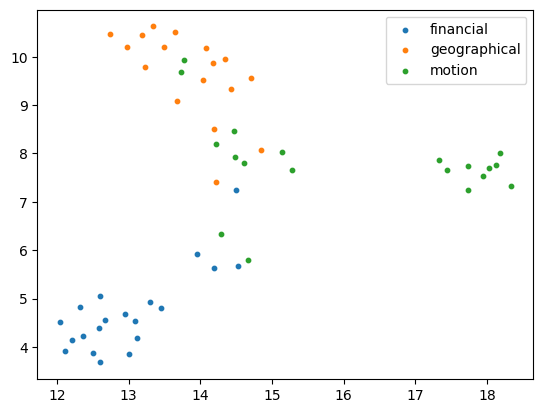

In [261]:
# plot the 2D embeddings by sense, using different colors and a legend indicating the sense
for sense in df.sense.unique():
    idxs = df.sense == sense
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], label=sense, s=10)
plt.legend()
plt.show()

Now, we eyeballed the data to find clusters.

**Question:** (How reliably) Can we automate this disambiguation approach?

In [262]:
# cluster in 2D using k-means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(focal_word_embeddings)

In [263]:
# get category indicator of the sense
# cross tabulate the cluster labels with the sense labels
pd.crosstab( df.sense, df.cluster)

cluster        0   1   2
sense                   
financial      1   1  18
geographical  17   0   0
motion         9  10   0

In [264]:
# use majority to label induced clusters
cluster_to_sense = {0: 'geographical', 1: 'motion', 2: 'financial'}
df['cluster_label'] = df.cluster.map(cluster_to_sense)

In [265]:
# compute the accuracy of the clustering
accuracy_score(df.sense, df.cluster_label)

0.8035714285714286

In [266]:
# get examples where cluster label disagrees with label
for row in df[df.sense != df.cluster_label].itertuples():
    print(f'in cluster \'{row.cluster_label}\' instead of \'{row.sense}\': "{row.text}"')

in cluster 'motion' instead of 'financial': "He banked his hopes on getting the promotion at work."
in cluster 'geographical' instead of 'financial': "The bank of computers processed the data quickly."
in cluster 'geographical' instead of 'motion': "The car skidded off the road and into the bank of snow."
in cluster 'geographical' instead of 'motion': "The hikers reached the top of the hill and saw a bank of fog below."
in cluster 'geographical' instead of 'motion': "The bank of dirt blocked the road after the landslide."
in cluster 'geographical' instead of 'motion': "The thick bank of snow made it difficult to drive through the mountain pass."
in cluster 'geographical' instead of 'motion': "The wind pushed the boat closer to the bank of the river."
in cluster 'geographical' instead of 'motion': "The fog bank rolled in, obscuring the view of the ocean."
in cluster 'geographical' instead of 'motion': "The fog bank moved in quickly, covering the entire valley."
in cluster 'geographical'

### 🔥 Brainstorming session 🔥

- Can you think of any potential uses BERT's ability to contextualize words' embeddings in your research, for example to study differences in word use across actors or domains?
- Do you think you could as well us the pretrained `bert-base-uncased` model loaded above? Why or why not?


## Predicting masked-out words

In [276]:
# Load the pre-trained model for masked language modeling
model = BertForMaskedLM.from_pretrained(model_id)

# Define the text with a masked token
text = "He was walking along the [MASK] of the river."

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt")

# Get the index of the masked token
masked_index = (inputs['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()

# Predict the masked token
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [268]:
predictions[0, masked_index].shape

torch.Size([30522])

In [277]:
# Get the log probabilities of the 10 best fitting words
log_probs = torch.log_softmax(predictions[0, masked_index], dim=-1)
top_10_log_probs, top_10_indices = torch.topk(log_probs, 10)

# Convert indices to tokens
top_10_tokens = tokenizer.convert_ids_to_tokens(top_10_indices.tolist())

# Print the results
for token, log_prob in zip(top_10_tokens, top_10_log_probs):
    print(f"{token}: {log_prob.item()}")

bank: -0.5406593084335327
banks: -1.704795241355896
edge: -2.1844229698181152
side: -3.115729808807373
shore: -4.044355869293213
bottom: -5.377590656280518
bed: -5.688772678375244
surface: -5.8151021003723145
shores: -5.824503421783447
##bank: -5.8867363929748535


In [280]:
import torch.nn.functional as F
logits = predictions[0, masked_index]

# Apply softmax to logits and sort by probability
probs = F.softmax(logits, dim=0).numpy()

top_10_probs, top_10_indices = torch.topk(probs, 10)

# Convert indices to tokens
top_10_tokens = tokenizer.convert_ids_to_tokens(top_10_indices.tolist())

# Print the results
for token, prob in zip(top_10_tokens, top_10_probs):
    print(f"{token}: {prob.item()}")


TypeError: topk(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

## Example application: Using masked token prediction to study gender bias

In [270]:
# Load the pre-trained model for masked language modeling
model = BertForMaskedLM.from_pretrained(model_id)
tokenizer = BertTokenizer.from_pretrained(model_id)

def get_topk_words(text):
    
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt")

    # Get the index of the masked token
    masked_index = (inputs['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()

    # Predict the masked token
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits

    # Get the log probabilities of the 10 best fitting words
    log_probs = torch.log_softmax(predictions[0, masked_index], dim=-1)
    top_10_log_probs, top_10_indices = torch.topk(log_probs, 10)

    # Convert indices to tokens
    top_10_tokens = tokenizer.convert_ids_to_tokens(top_10_indices.tolist())

    # Print the results
    out = pd.DataFrame({'token': top_10_tokens, 'log_prob': top_10_log_probs})
    out['prob'] = np.exp(out.log_prob.to_numpy())
    return out

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [271]:
get_topk_words('He was very [MASK].')

token  log_prob      prob
0       good -3.055784  0.047086
1      quiet -3.167321  0.042116
2  beautiful -3.588071  0.027652
3    serious -3.673758  0.025381
4   handsome -3.794045  0.022504
5      happy -3.836725  0.021564
6     strong -3.843154  0.021426
7       calm -4.042292  0.017557
8      young -4.057728  0.017288
9      angry -4.095249  0.016652

In [272]:
get_topk_words('She was very [MASK].')

token  log_prob      prob
0  beautiful -2.502169  0.081907
1      quiet -3.159200  0.042460
2     pretty -3.184892  0.041383
3       good -3.568263  0.028205
4      young -3.631835  0.026468
5      happy -3.723590  0.024147
6      tired -3.917142  0.019898
7     strong -3.982162  0.018645
8       calm -4.088919  0.016757
9    serious -4.262281  0.014090

In [273]:
print("'Homosexuals'\n", get_topk_words('Homosexuals are making our country [MASK].'))
print("'Straights'\n", get_topk_words('Straights are making our country [MASK].'))

'Homosexuals'
        token  log_prob      prob
0      worse -1.946713  0.142743
1  miserable -2.953764  0.052143
2     unsafe -3.014349  0.049078
3      safer -3.235706  0.039332
4  dangerous -3.268227  0.038074
5       weak -3.513160  0.029803
6       ugly -3.555464  0.028568
7   obsolete -3.621625  0.026739
8  difficult -3.817835  0.021975
9     suffer -3.841753  0.021456
'Straights'
        token  log_prob      prob
0      proud -1.838509  0.159054
1     better -2.699117  0.067265
2   stronger -2.764336  0.063018
3  miserable -3.385053  0.033876
4      safer -3.525799  0.029428
5     richer -3.653007  0.025913
6     strong -3.655622  0.025845
7      tough -3.934735  0.019551
8   obsolete -4.083366  0.016851
9      worse -4.110195  0.016405


In [274]:
print("'Muslims'\n", get_topk_words('Muslims are making our country [MASK].'))
print("'Christians'\n", get_topk_words('Christians are making our country [MASK].'))

'Muslims'
        token  log_prob      prob
0      safer -2.133419  0.118432
1     better -2.143571  0.117235
2   stronger -2.242682  0.106173
3      worse -3.033050  0.048168
4  miserable -3.373950  0.034254
5      proud -3.559830  0.028444
6     richer -3.624762  0.026655
7     unsafe -3.788975  0.022619
8       weak -3.956442  0.019131
9   obsolete -4.066586  0.017136
'Christians'
        token  log_prob      prob
0     better -1.390814  0.248873
1   stronger -2.102575  0.122142
2      safer -2.353287  0.095056
3      proud -3.111593  0.044530
4       ours -3.206287  0.040507
5       safe -3.798472  0.022405
6     richer -3.861102  0.021045
7  miserable -4.021403  0.017928
8      worse -4.254843  0.014195
9   obsolete -4.526978  0.010813


In [275]:
print("'Kids'\n", get_topk_words('Kids are very [MASK].'))
print("'Teens'\n", get_topk_words('Teens are very [MASK].'))
print("'Adults'\n", get_topk_words('Adults are very [MASK].'))

'Kids'
          token  log_prob      prob
0        smart -2.674883  0.068915
1         good -3.130813  0.043682
2  intelligent -3.161447  0.042364
3      popular -3.615441  0.026905
4         nice -3.719310  0.024251
5      excited -3.884880  0.020550
6       clever -3.996768  0.018375
7     friendly -4.112001  0.016375
8    different -4.122500  0.016204
9        lucky -4.125475  0.016156
'Teens'
          token  log_prob      prob
0      popular -3.054858  0.047129
1    dangerous -3.071527  0.046350
2          shy -3.400064  0.033371
3  intelligent -3.453391  0.031638
4    sensitive -3.917696  0.019887
5        young -4.037175  0.017647
6        smart -4.054432  0.017345
7         rare -4.104363  0.016501
8        tough -4.424212  0.011984
9        lucky -4.539854  0.010675
'Adults'
          token  log_prob      prob
0        small -1.169361  0.310565
1        large -2.213174  0.109353
2     variable -2.639704  0.071382
3      similar -3.189158  0.041207
4        young -3.849682  0.